In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
!pip install torch==1.5.1

In [56]:
!pip install transformers

In [57]:
% pip install sentencepiece

In [58]:
import os
import math

import torch
from torch.nn import CrossEntropyLoss
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig, get_linear_schedule_with_warmup
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from sklearn.utils import shuffle
from sklearn import metrics
import pandas as pd
from pylab import rcParams
import seaborn as sns
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla P100-PCIE-16GB


In [60]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [61]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Engine_design/Data_Aug/trainset_int1.csv')
df1.head()

,body,intent_1
0,0.11,NAN
1,2.47,NAN
2,2.5,NAN
3,?,Asking for information
4,*myself,NAN


In [62]:
df1 = shuffle(df1)
df1= df1[:516]
len(df1)

516

In [63]:
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Engine_design/Data_Aug/Validation_data_i1.csv')
df2 = shuffle(df2)
len(df2)

48

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Frequency of categories')

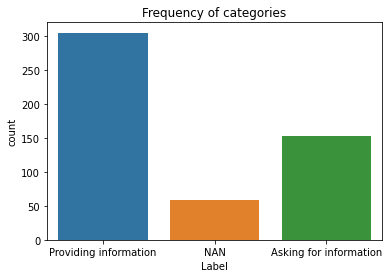

In [64]:
sns.countplot(df1['intent_1'])
plt.xlabel('Label')
plt.title('Frequency of categories')

In [65]:
df1['Body'] = df1['body'].astype('str')

In [66]:

df2['Body'] = df2['body'].astype('str')
df2['Intent'] = df2['intent_1'].astype("category")
print(df2['Intent'].unique)
df2.drop(labels=["intent_1","body"], axis=1,inplace=True)
df2['Intent'] = df2['Intent'].cat.codes

<bound method Series.unique of 17     Providing information
36                       NAN
38                       NAN
31     Providing information
7     Asking for information
25     Providing information
14    Asking for information
29    Asking for information
43    Asking for information
5     Asking for information
44     Providing information
11     Providing information
37     Providing information
10    Asking for information
19    Asking for information
33     Providing information
15    Asking for information
9      Providing information
47     Providing information
27     Providing information
0     Asking for information
26     Providing information
35                       NAN
45     Providing information
8      Providing information
13     Providing information
40     Providing information
22     Providing information
23     Providing information
39                       NAN
18     Providing information
4     Asking for information
28    Asking for information
24          

In [67]:
df1['Intent'] = df1['intent_1'].astype("category")

In [68]:
df1.drop(labels=["intent_1","body"], axis=1,inplace=True)

In [69]:
df1['Intent']

27      Providing information
54      Providing information
304     Providing information
221     Providing information
65      Providing information
                ...          
415     Providing information
320     Providing information
422    Asking for information
508                       NAN
184     Providing information
Name: Intent, Length: 516, dtype: category
Categories (3, object): ['Asking for information', 'NAN', 'Providing information']

In [70]:
df1['Intent'] = df1['Intent'].cat.codes

In [71]:
class_names = ['Asking for information', 'NAN', 'Providing information']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


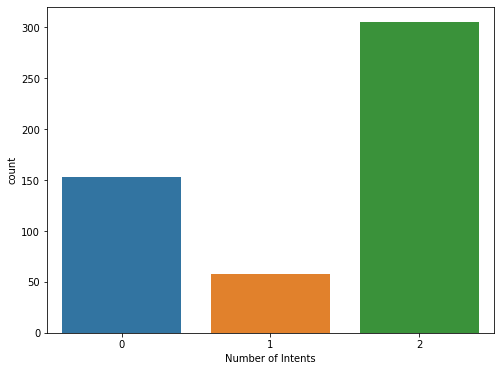

In [72]:
rcParams['figure.figsize'] = 8, 6
sns.countplot(df1.Intent)
plt.xlabel('Number of Intents');

In [73]:
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [74]:
token_lens = []

for txt in df1['Body']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


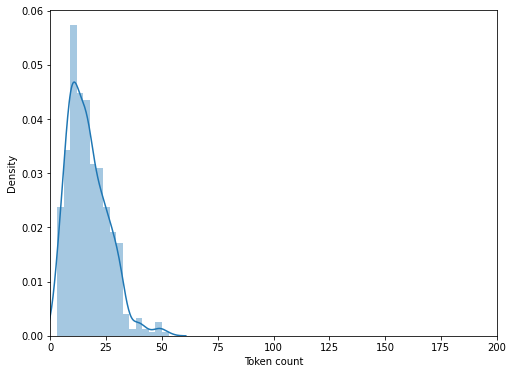

In [75]:
sns.distplot(token_lens)
plt.xlim([0, 200]);
plt.xlabel('Token count');

In [76]:
class QaDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'review_text': review,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }


In [77]:
df_train = df1
df_val = df2

In [78]:
df_train.shape, df_val.shape

((516, 2), (48, 2))

In [79]:
#df_train = df_train.iloc[0:2748,]

In [80]:
#df_val = df_val.iloc[0:1372,]

In [81]:
#df_test = df_test.iloc[0:1372,]

In [82]:
#df_train.shape, df_val.shape

In [83]:
MAX_LEN=512

In [84]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = QaDataset(
    reviews=df.Body.to_numpy(),
    targets=df.Intent.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [85]:
BATCH_SIZE = 2
MAX_LEN
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
#test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [86]:
from transformers import XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 3)
model = model.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [87]:
EPOCHS = 2

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [88]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [89]:
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].reshape(2,512).to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]

        # preds = preds.cpu().detach().numpy()
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())
        
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1

    return acc / counter, np.mean(losses)

In [90]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].reshape(2,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)


In [91]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,     
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader, 
        device, 
        len(df_val)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/QA/models/xlnet_modelnd.bin')
        best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.9813084679749585 Train accuracy 0.6201550387596899
Val loss 1.3395045200983684 Val accuracy 0.75

Epoch 2/2
----------
Train loss 0.8111315481653509 Train accuracy 0.8275193798449613
Val loss 1.2537776802976925 Val accuracy 0.8333333333333334

CPU times: user 1min 53s, sys: 2.66 s, total: 1min 56s
Wall time: 1min 54s


In [92]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/QA/models/xlnet_modelnd.bin'))

<All keys matched successfully>

In [93]:
model = model.to(device)

In [94]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].reshape(2,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [95]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)


In [96]:
print(classification_report(y_test, y_pred, target_names=class_names))

                        precision    recall  f1-score   support

Asking for information       0.91      0.77      0.83        13
                   NAN       1.00      0.43      0.60         7
 Providing information       0.79      0.96      0.87        28

              accuracy                           0.83        48
             macro avg       0.90      0.72      0.77        48
          weighted avg       0.86      0.83      0.82        48



In [97]:
def predict_sentiment(text):
    review_text = text

    encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=False,
    return_attention_mask=True,
    return_tensors='pt',
    )

    input_ids = pad_sequences(encoded_review['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    input_ids = input_ids.astype(dtype = 'int64')
    input_ids = torch.tensor(input_ids) 

    attention_mask = pad_sequences(encoded_review['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    attention_mask = attention_mask.astype(dtype = 'int64')
    attention_mask = torch.tensor(attention_mask) 

    input_ids = input_ids.reshape(1,512).to(device)
    attention_mask = attention_mask.to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    outputs = outputs[0][0].cpu().detach()
    print(outputs)

    probs = F.softmax(outputs, dim=-1).cpu().detach().numpy().tolist()
    _, prediction = torch.max(outputs, dim =-1)
    
   
    print("-----------------------------------------")
    print(f'Message : {review_text}')
    print("-----------------------------------------")
    print(f'Intent  : {class_names[prediction]}')

In [98]:
text = "mass reduced as i decreased crankshaft dia"
predict_sentiment(text)

tensor([-2.2956, -2.5754,  5.7943])
-----------------------------------------
Message : mass reduced as i decreased crankshaft dia
-----------------------------------------
Intent  : Providing information


In [99]:
text = "my ratio depnds on your crankshaft dia"
predict_sentiment(text)

tensor([-2.2173, -2.4983,  5.6468])
-----------------------------------------
Message : my ratio depnds on your crankshaft dia
-----------------------------------------
Intent  : Providing information


In [104]:
text = " feeling happy  "
predict_sentiment(text)

tensor([-1.3528,  1.9873, -0.4921])
-----------------------------------------
Message :  feeling happy  
-----------------------------------------
Intent  : NAN


In [101]:
text = "flywheel says they have an FOS of 3286 apparently?"
predict_sentiment(text)

tensor([ 5.9639, -2.6606, -2.3855])
-----------------------------------------
Message : flywheel says they have an FOS of 3286 apparently?
-----------------------------------------
Intent  : Asking for information


In [102]:
text = "i will try increasing diameter value of shaft"
predict_sentiment(text)

tensor([-2.2068, -2.5256,  5.7756])
-----------------------------------------
Message : i will try increasing diameter value of shaft
-----------------------------------------
Intent  : Providing information


In [103]:
text = "Keep 70 mm I'm trying to get out of the poor region"
predict_sentiment(text)

tensor([-2.3336, -2.6102,  5.8012])
-----------------------------------------
Message : Keep 70 mm I'm trying to get out of the poor region
-----------------------------------------
Intent  : Providing information
